In [0]:
# Install some packages
!pip install dask[complete] toolz cloudpickle
!pip install -U feather-format
!pip install pyarrow==0.09.0
!pip install --upgrade pandas
!pip install lightgbm

In [2]:
import pandas as pd 
from tqdm import tqdm
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
%matplotlib inline
plt.style.use('ggplot')

TRAIN_PATH = 'drive/My Drive/train.csv'
TEST_PATH = 'drive/My Drive/test.csv'

# 1. Data cleaning on a subset 1.000.000 rows

In [0]:
train = pd.read_csv(TRAIN_PATH, nrows = 1000000)

In [0]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
# Some statistics descriptive:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


**Lưu ý:** 
- `fare_amount`: negative value and max = 500$.
- `longitude` and `latitude`: big diffenrence between max, min and quantiles.
- `passenger_count`: max = 208 peoples???

In [0]:
# Check missing values
train.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

In [0]:
# Missing values not much, simply remove it
train = train.drop(train.loc[train.isnull().any(1)].index, axis = 0)

In [0]:
# Check `fare_amount` how many negative values?
len(train.loc[train['fare_amount'] < 0])

38

In [0]:
# obs `fare_amount` not much, simply remove it:
train = train.drop(train.loc[train['fare_amount'] < 0].index, axis = 0)

In [0]:
# Normally 7 passengers in a taxi, then check how many cases:
train.loc[train['passenger_count'] > 7]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
929022,2009-07-30 11:54:00.000000193,3.3,2009-07-30 11:54:00 UTC,0.0,0.0,0.0,0.0,208


In [0]:
# we'll remove them:
train = train.drop(train.loc[train['passenger_count'] > 7].index, axis = 0)

In [0]:
# Check information: New York City latitude between -90 and 90, longitude from -180 to 180 
train.loc[(train['pickup_latitude'] < -90) | (train['pickup_latitude'] > 90)].shape[0]

12

In [0]:
train.loc[(train['dropoff_latitude'] < -90) | (train['dropoff_latitude'] > 90)].shape[0]

12

In [0]:
train.loc[(train['pickup_longitude'] < -180) | (train['pickup_longitude'] > 180)].shape[0]

15

In [0]:
train.loc[(train['dropoff_longitude'] < -180) | (train['dropoff_longitude'] > 180)].shape[0]

13

In [0]:
# We need to remove them:
train = train.drop(train.loc[(train['pickup_latitude'] < -90) | (train['pickup_latitude'] > 90)].index, axis = 0)
train = train.drop(train.loc[(train['dropoff_latitude'] < -90) | (train['dropoff_latitude'] > 90)].index, axis = 0)
train = train.drop(train.loc[(train['pickup_longitude'] < -180) | (train['pickup_longitude'] > 180)].index, axis = 0)
train = train.drop(train.loc[(train['dropoff_longitude'] < -180) | (train['dropoff_longitude'] > 180)].index, axis = 0)

In [0]:
# Convert `pickup_datetime` to pandas date time:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

In [0]:
# Define a function allow us to compute distance given latitude and longitude 2 points in map:
def haversine_distance(lat1, long1, lat2, long2, dataset):
    R = 6371  #radius of earth in kilometers
    phi1 = np.radians(dataset[lat1])
    phi2 = np.radians(dataset[lat2])

    delta_phi = np.radians(dataset[lat2] - dataset[lat1])
    delta_lambda = np.radians(dataset[long2] - dataset[long1])
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    #d = R*c
    d = (R * c) #in kilometers
    dataset['H_Distance'] = d
    return dataset

In [0]:
# Compute the distance between pickup và dropoff
train = haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', train)

In [0]:
# Define variables `Year`, `Month`, `Date`, `Day of week`, `Hour`:
train['Year'] = train['pickup_datetime'].dt.year
train['Month'] = train['pickup_datetime'].dt.month
train['Date'] = train['pickup_datetime'].dt.day
train['Day of Week'] = train['pickup_datetime'].dt.dayofweek
train['Hour'] = train['pickup_datetime'].dt.hour

In [0]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010,1,5,1,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011,8,18,3,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010,3,9,1,7


In [0]:
# Check statistic descriptive
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
count,999911.000000,999911.000000,999911.000000,999911.000000,999911.000000,999911.000000,999911.000000,999911.000000,999911.000000,999911.000000,999911.000000,999911.000000
mean,11.348597,-72.517395,39.926794,-72.515537,39.926038,1.684734,18.890787,2011.741039,6.268010,15.697940,3.039845,13.509595
std,9.821236,10.393285,6.089238,10.396301,6.093210,1.307722,360.390394,1.860751,3.436245,8.682462,1.949968,6.513805
min,0.000000,-128.175950,-74.016587,-121.391248,-74.035197,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734047,1.000000,1.212957,2010.000000,3.000000,8.000000,1.000000,9.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000,2.115891,2012.000000,6.000000,16.000000,3.000000,14.000000
75%,12.500000,-73.967095,40.767153,-73.963654,40.768129,2.000000,3.882180,2013.000000,9.000000,23.000000,5.000000,19.000000
max,500.000000,40.850357,69.400000,45.581619,81.510177,6.000000,12594.704725,2015.000000,12.000000,31.000000,6.000000,23.000000


**Nhận xét:**
- `fare_amount`: max 500$.
- Values longtitude, latitude and `passenger_count`: ok.
- `H_Distance`: big values std and max (quantiles ok).

# 2. Exploratory data analysis (EDA) 

## 2.1. Dependent variable: `fare_amount`

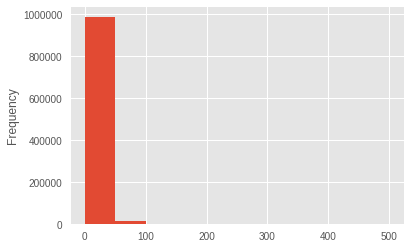

In [0]:
# Check distribution:
train['fare_amount'].plot.hist()

**Nhận xét:** `fare_amount` right skewed -> fare taxi focus on interval 0-50 $

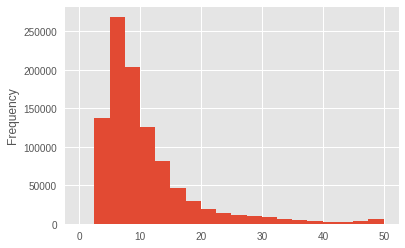

In [0]:
# Check distribution between 0-50$
train['fare_amount'].loc[train.loc[train['fare_amount'] < 50].index].plot.hist(bins = 20)

In [0]:
# Check very big values `fare_amount`:
train.loc[train['fare_amount'] > 300]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
101885,2011-09-12 09:33:56.0000004,500.00,2011-09-12 09:33:56,-73.965961,40.640595,-73.965961,40.640595,1,0.000000,2011,9,12,0,9
233874,2012-10-28 14:14:44.0000001,450.00,2012-10-28 14:14:44,-73.931985,40.793829,-73.929148,40.799672,1,0.692212,2012,10,28,6,14
247671,2015-05-12 13:16:47.0000004,495.00,2015-05-12 13:16:47,-73.814911,40.699562,-72.196091,41.012253,1,140.514983,2015,5,12,1,13
287638,2015-03-11 16:25:21.0000007,450.00,2015-03-11 16:25:21,-73.909019,40.777611,-73.908997,40.777607,1,0.001973,2015,3,11,2,16
329010,2011-07-29 14:19:00.000000200,450.00,2011-07-29 14:19:00,-73.955373,40.810310,-73.955372,40.810323,1,0.001448,2011,7,29,4,14
361793,2011-05-05 08:39:00.00000018,400.00,2011-05-05 08:39:00,-73.852663,40.897932,-73.852673,40.897923,1,0.001307,2011,5,5,3,8
451974,2011-10-08 05:17:04.0000002,400.00,2011-10-08 05:17:04,-73.943676,40.708061,-73.943665,40.708141,1,0.008944,2011,10,8,5,5
951810,2015-03-24 17:14:27.0000001,347.54,2015-03-24 17:14:27,-73.811020,40.693180,-73.138634,41.261410,1,84.724849,2015,3,24,1,17


**Nhận xét:** Có 8 obs `fare_amount` lớn hơn 300$, trong khi hầu hết quãng đường lại rất ngắn -> chắc chắn ảnh hưởng đến prediction nếu cứ giữ nguyên.

In [0]:
# Check whether 'fare_amount' > 100$
len(train.loc[train['fare_amount'] > 100])

396

In [0]:
# Check whether 'fare_amount' = 0
len(train.loc[train['fare_amount'] == 0])

29

## 2.2. `passenger_count` variable

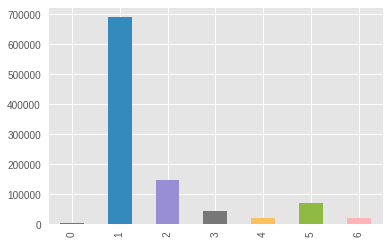

In [0]:
# Đếm số lượng obs của từng loại
train['passenger_count'].value_counts().sort_index().plot.bar()

**Nhận xét:** Có thể thấy số lượng hành khách là 1, 2, 5 chiếm đa số trong dataset.

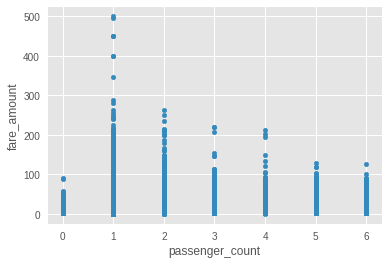

In [0]:
# Biểu diễn quan hệ giữa `fare_amount` và `passenger_count`
train.plot.scatter(x = 'passenger_count', y = 'fare_amount')

**Nhận xét:** Có thể thấy số lượng khách hàng càng ít thì giá cước taxi có xu hướng cao hơn trong bộ dataset này (lưu ý số lượng khách hàng là 0 có thể hiểu là trường hợp taxi chờ khách hàng nhưng sau đó KH hủy chuyến đi nên họ vẫn phải thanh toán)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


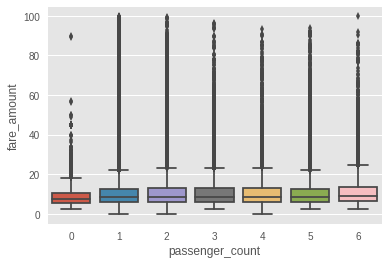

In [0]:
# Check bằng boxplot để xem từng số lượng hành khách thì `fare_amount` nằm chủ yếu ở khoảng nào
sns.boxplot(x = 'passenger_count', y = 'fare_amount', data = train.loc[train['fare_amount'] < 100])

## 2.3. `Year` variable

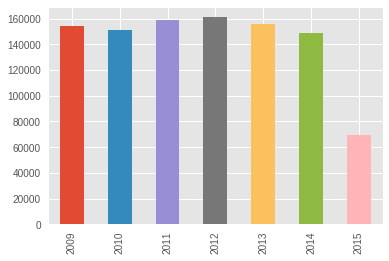

In [0]:
# Check số lượng data theo từng năm:
train['Year'].value_counts().sort_index().plot.bar()

**Nhận xét:** Có thể thấy số lượng data từng năm khá tương đồng, ngoại trừ năm 2015 có vẻ ít hơn.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


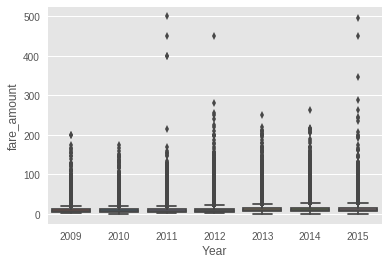

In [0]:
# Check mối quan hệ với `fare_amount`
sns.boxplot(x = 'Year', y = 'fare_amount', data = train)

**Nhận xét:** Qua từng năm thì mức độ tập trung của `fare_amount` khá là tương đồng, ngoại trừ một số mức giá đặc biệt trên 300$ xuất hiện ở những năm 2011, 2012 và 2015 -> năm dường như không tác động quá nhiều đến mức giá trung bình.

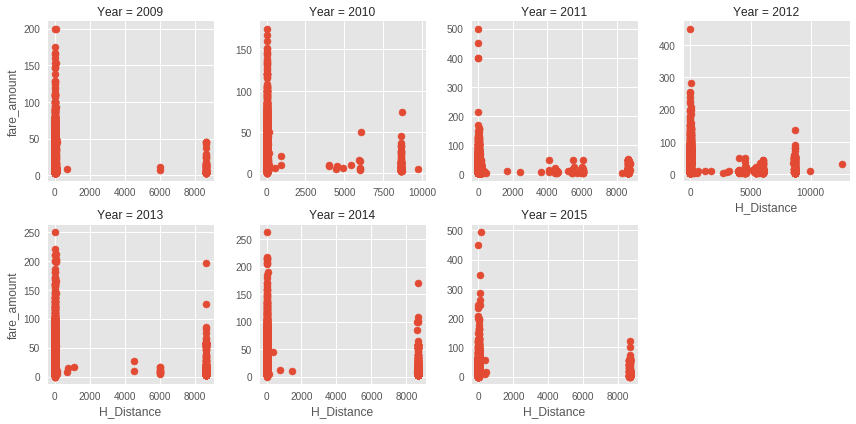

In [0]:
# Biểu diễn `fare_amount` theo `H_Distance` qua từng năm:
g = sns.FacetGrid(train, col = 'Year', col_wrap = 4, sharex = False, sharey = False)
g.map(plt.scatter, 'H_Distance', 'fare_amount')

**Nhận xét:** Có thể thấy tồn tại rất nhiều obs với khoảng cách trên 1000km -> cần phải phân tích và xử lý ở phần sau

## 2.4. `Day of week` variable

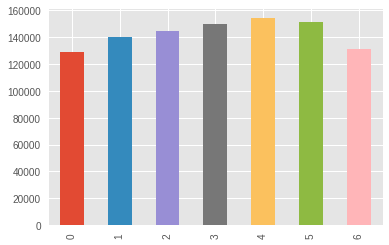

In [0]:
# Check số lượng data theo từng ngày trong tuần:
train['Day of Week'].value_counts().sort_index().plot.bar()

**Nhận xét:** Số lượng data theo từng ngày trong tuần khá tương đồng.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


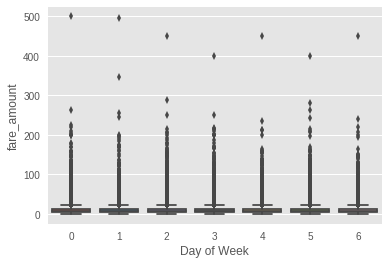

In [0]:
# Check mối quan hệ với `fare_amount`
sns.boxplot(x = 'Day of Week', y = 'fare_amount', data = train)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


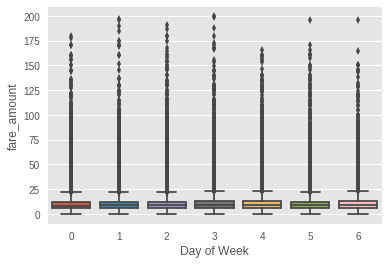

In [0]:
# Check mối quan hệ với `fare_amount`
sns.boxplot(x = 'Day of Week', y = 'fare_amount', data = train.loc[train['fare_amount'] < 200])

**Nhận xét:** Có thể thấy phân phối của `fare_amount` từng ngày trong tuần không có sự khác biệt rõ rệt, kể cả Thứ Bảy Chủ nhật (5, 6)

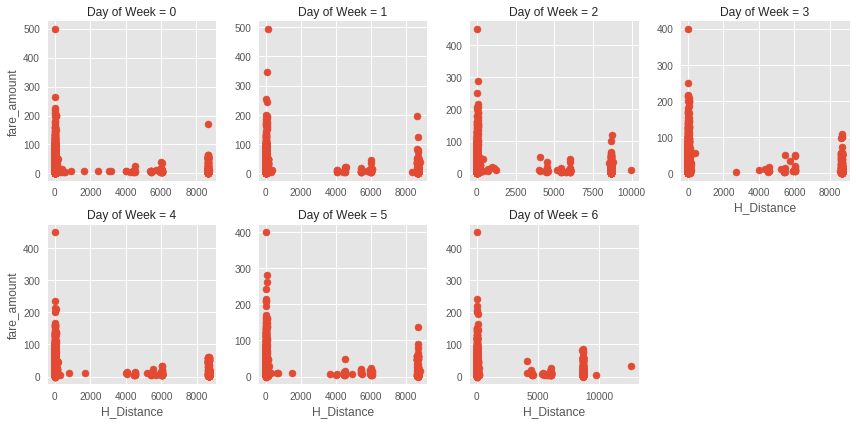

In [0]:
# Biểu diễn `fare_amount` theo `H_Distance` qua từng năm:
g = sns.FacetGrid(train, col = 'Day of Week', col_wrap = 4, sharex = False, sharey = False)
g.map(plt.scatter, 'H_Distance', 'fare_amount')

**Nhận xét:** Có thể thấy tồn tại rất nhiều obs với khoảng cách trên 1000km -> cần phải phân tích và xử lý ở phần sau

## 2.5. `Hour` variable

In [0]:
# Create `rush_hour` variable
train['rush_hour'] = train['Hour'].apply(lambda x: 'Yes' if ((x >= 6) & (x <= 20)) else 'No')

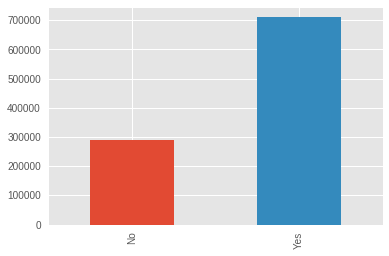

In [0]:
# Đếm số lượng data từng loại
train['rush_hour'].value_counts().sort_index().plot.bar()

**Nhận xét:** Số lượng data thuộc giờ cao điểm chiếm phần lớn trong dataset

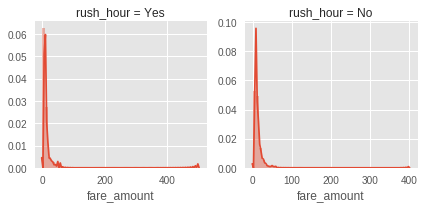

In [0]:
# Check phân phối của `fare_amount` giờ cao điểm
g = sns.FacetGrid(train, col = 'rush_hour', col_wrap = 2, sharex = False, sharey = False)
g.map(sns.distplot, 'fare_amount')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


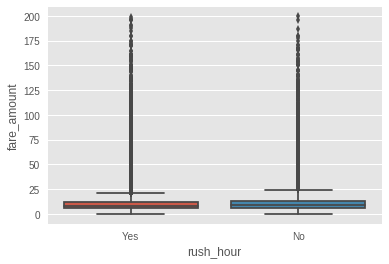

In [0]:
# Check phân phối của `fare_amount` giờ cao điểm
sns.boxplot(x = 'rush_hour', y = 'fare_amount', data = train.loc[train['fare_amount'] < 200])

**Nhận xét:** Phân phối của `fare_amount` giờ cao điểm và không cao điểm khá tương đồng.

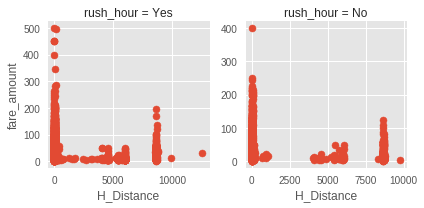

In [0]:
# Check mối quan hệ giữa `fare_amount` và `H_Distance` từng loại giờ
g = sns.FacetGrid(train, col = 'rush_hour', col_wrap = 2, sharex = False, sharey = False)
g.map(plt.scatter, 'H_Distance', 'fare_amount')

In [0]:
# Create `weekend` variable
train['weekend'] = train['Day of Week'].apply(lambda x: 'Yes' if ((x == 5) | (x == 6)) else 'No')

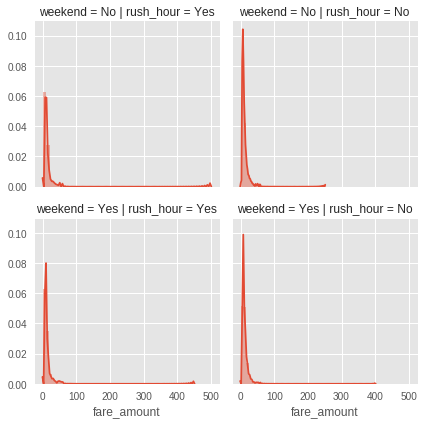

In [0]:
g = sns.FacetGrid(train, col = 'rush_hour', row = 'weekend')
g.map(sns.distplot, 'fare_amount')

**Nhận xét:** Có thể thấy rằng những giờ không phải cao điểm (từ 20h đến 6h sáng hôm sau) có mức độ tập trung giá taxi cao hơn giờ cao điểm, cả những ngày cuối tuần và ngày làm việc.

## 2.6. `H_Distance` variable

Một số ý tưởng lấy từ "https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters"

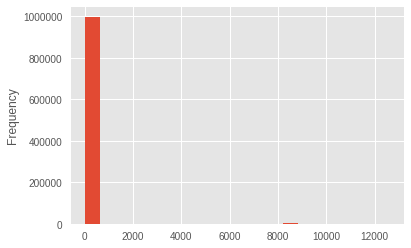

In [0]:
# Kiểm tra phân phối của `H_Distance`
train['H_Distance'].plot.hist(bins = 20)

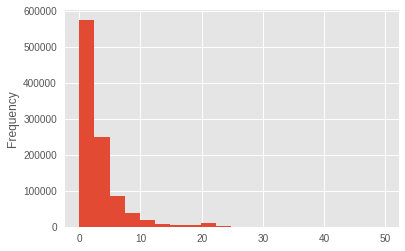

In [0]:
# Kiểm tra phân phối của `H_Distance` < 50km
train['H_Distance'].loc[train.loc[train['H_Distance'] < 50].index].plot.hist(bins = 20)

In [0]:
# Check số lượng khoảng cách lớn hơn 300km
train.loc[train['H_Distance'] > 300].shape[0]

1928

In [0]:
# Tạo biến chia khoảng cách =0, 0-10, 11-50, >50km
train['distance_bins'] = train['H_Distance'].apply(lambda x: '0' if x == 0 else ('0-10' if x <= 10 else ('11-50' if x <= 50 else ('>50'))))

In [0]:
# Đếm số lượng từng bin
train['distance_bins'].value_counts().sort_values()

>50        2286
0         28481
11-50     49073
0-10     920071
Name: distance_bins, dtype: int64

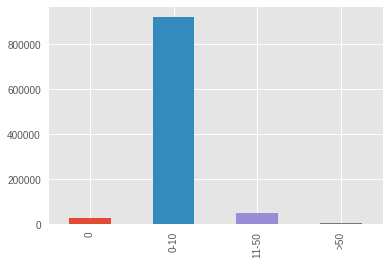

In [0]:
# Plot số lượng từng bin
train['distance_bins'].value_counts().sort_index().plot.bar()

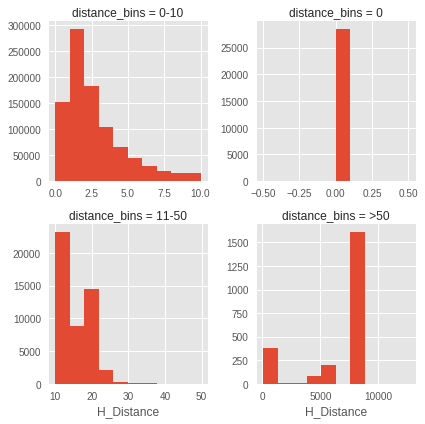

In [0]:
# Kiếm tra phân phối `H_Distance` từng bin
g = sns.FacetGrid(train, col = 'distance_bins', col_wrap = 2, sharex = False, sharey = False)
g.map(plt.hist, 'H_Distance') 

**Nhận xét:** Có thể thấy rằng khoảng cách 0-10 chiếm phần lớn trong dataset và right skewed

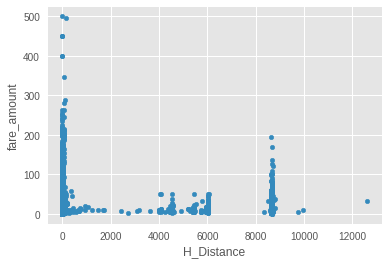

In [0]:
# Kiểm tra mối quan hệ với `fare_amount`
train.plot.scatter(x = 'H_Distance', y = 'fare_amount')

**Nhận xét:** Nhìn vào figure này thì khó có thể đánh giá liên hệ nào giữa 2 biến `fare_amount` và `H_Distance`. Có những khoảng cách rất nhỏ nhưng giá tiền rất cao, khoảng cách rất lớn (>2000km) nhưng giá tiền lại rất nhỏ. Do đó cần phải xử lý những data thuộc outliers như này

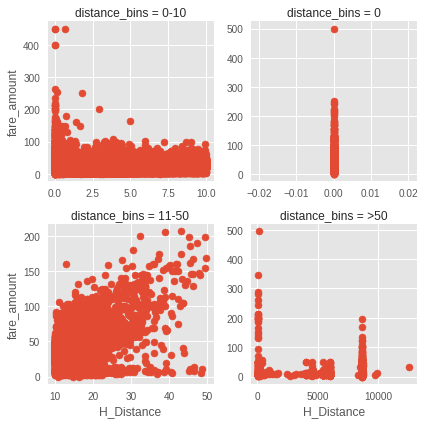

In [0]:
# Plot `fare_amount` và `H_Distance` theo `distance_bins`
g = sns.FacetGrid(train, col = 'distance_bins', col_wrap = 2, sharex = False, sharey = False)
g.map(plt.scatter, 'H_Distance', 'fare_amount') 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


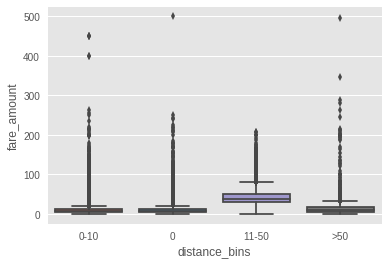

In [0]:
# Plot distribution của `fare_amount` theo `distance_bins`
sns.boxplot(x = 'distance_bins', y = 'fare_amount', data = train)

**Nhận xét:** Thấy rằng bin 11-50km có giá cước taxi có xu hướng cao hơn so với các bin khác và mối quan hệ với `H_Distance` dạng tuyến tính (nhưng high variance). Bin >50 có ít data nhất và dường như không có liên hệ với `fare_amount`

**Check giá taxi tại New York City:** https://www.taxi-calculator.com/taxi-fare-new-york-city/259

- Từ thứ Hai đến thứ Sáu (6h sáng đến 20h tối): Giá mở cửa 2.5 USD, 1.56USD/km, waiting time: 30 USD/h
- Từ thứ Hai đến thứ Sáu (từ 20h tối đến 6h sáng) và Cuối tuần: Giá mở cửa 3.0 USD, 1.56 USD/km, waiting time: 30 USD/h.

In [0]:
# Đếm số lượng khoảng cách = 0km và giá cước nhỏ hơn giá mở cửa, đây là những data không thể giải thích được
train.loc[(train['distance_bins'] == '0') & (train['fare_amount'] < 2.5)].shape[0]

6

In [0]:
# Drop obs co khoảng cách = 0 nhưng fare < giá mở cửa
train = train.drop(train.loc[(train['H_Distance'] == 0) & (train['fare_amount'] < 2.5)].index, axis = 0)

In [0]:
# Đếm số lượng obs có khoảng cách = 0 nhưng fare > 3.0 USD
train.loc[(train['H_Distance'] == 0) & (train['fare_amount'] > 3.0)].shape[0]

27159

In [0]:
# Obs có khoảng cách = 0 nhưng fare > 3.0 USD chiếm số lượng rất lớn, những obs này có thể hiểu là trường hợp taxi chờ
# khách nhưng rồi khách hủy chuyến nên vẫn phải xuất hiện tiền phải trả. Nếu cứ để những obs này thì data trở nên không
# có cấu trúc bởi những trường hợp đặc biệt. Do đó ta nên impute chúng theo công thức liên hệ giá tiền và khoảng cách
index = train.loc[(train['H_Distance'] == 0) & (train['fare_amount'] > 3.0)].index
train['H_Distance'].loc[index] = train['fare_amount'].loc[index].apply(lambda x: (x - 2.5)/1.56)

In [0]:
# Đếm số lượng obs có khoảng cách > 300km
train.loc[train['H_Distance'] > 300].shape[0]

1929

In [0]:
# Những data có khoảng cách > 300km ta cũng thực hiện imputer theo công thức
index = train.loc[train['H_Distance'] > 300].index
train['H_Distance'].loc[index] = train['fare_amount'].loc[index].apply(lambda x: np.maximum(0, (x - 2.5)/1.56))

In [0]:
# Đếm số lượng obs giá cước = 0
train.loc[train['fare_amount'] == 0].shape[0]

25

In [0]:
# Thực hiện impute chúng theo công thức
index = train.loc[train['fare_amount'] == 0].index
train['fare_amount'].loc[index] = train['H_Distance'].loc[index].apply(lambda x: (x*1.56 + 2.5))

In [0]:
# Đếm số lượng obs có khoảng cách < 10km nhưng giá cước > 300 USD
train.loc[(train['H_Distance'] < 10) & (train['fare_amount'] > 300)].shape[0]

5

In [0]:
# Drop obs có khoảng cách < 10km nhưng giá cước > 300 USD
train = train.drop(train.loc[(train['H_Distance'] < 10) & (train['fare_amount'] > 300)].index, axis = 0)

In [0]:
# Kiểm tra lại dataset sau khi đã xử lý về `H_Distance` và `fare_amount`
train['distance_bins'] = train['H_Distance'].apply(lambda x: '0' if x == 0 else ('0-10' if x <= 10 else ('11-50' if x <= 50 else ('>50'))))

In [0]:
train['distance_bins'].value_counts().sort_values()

>50         522
0          1507
11-50     52760
0-10     945111
Name: distance_bins, dtype: int64

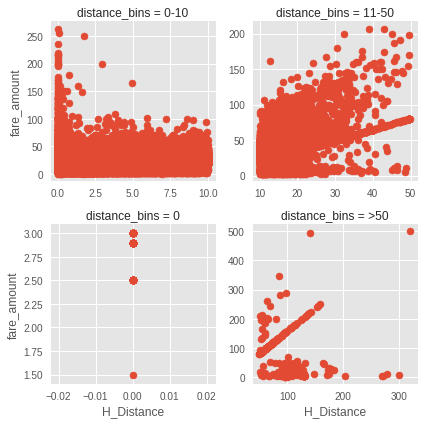

In [0]:
# Kiểm tra mối quan hệ giữa `H_Distance` và `fare_amount`
g = sns.FacetGrid(train, col = 'distance_bins', col_wrap = 2, sharex = False, sharey = False)
g.map(plt.scatter, 'H_Distance', 'fare_amount') 

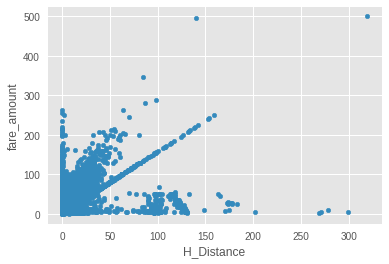

In [0]:
train.plot.scatter(x = 'H_Distance', y = 'fare_amount')

**Nhận xét:** Mối quan hệ giữa `H_Distance` và `fare_amount` đã trở nên khá dễ dàng giải thích, phù hợp để đưa vào các model

# 3. Train trên một số model

In [0]:
# Feature engineering: chọn toàn bộ các numeric variables để đưa vào model
train = train.loc[:, ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                   'passenger_count', 'H_Distance', 'Year', 'Month', 'Date', 'Day of Week', 'Hour']]

In [0]:
# Chia 10.000 obs làm tập validation, còn lại đưa vào training
X_train, X_val, Y_train, Y_val = train_test_split(train.iloc[:, 1:], train.iloc[:, 0], test_size = 10000, random_state = 167)

In [0]:
# Normalization: sử dụng MinMaxScaler đưa data về 0-1
scaler = MinMaxScaler()

In [0]:
X_train = scaler.fit_transform(X_train)

In [0]:
X_val = scaler.transform(X_val)

## 3.1. Linear Regression

In [0]:
LiR = LinearRegression()

In [0]:
LiR.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [0]:
Y_val_pred = LiR.predict(X_val)

In [0]:
print('RMSE on validation dataset = ', np.sqrt(mean_squared_error(Y_val, Y_val_pred)))

RMSE on validation dataset =  5.834422948737102


## 3.2. Ridge Regression

In [0]:
params = {'alpha': [1, 10, 20, 50, 80, 100]}

In [0]:
ridge_model = Ridge()

In [0]:
clf = GridSearchCV(ridge_model, param_grid = params, cv = 5, scoring = 'neg_mean_squared_error')

In [0]:
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 10, 20, 50, 80, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [0]:
clf.best_params_

{'alpha': 1}

In [0]:
clf.best_score_

-37.36451046979824

In [0]:
ridge_model = Ridge(alpha = 1)
ridge_model.fit(X_train, Y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
Y_val_pred = ridge_model.predict(X_val)

In [0]:
print('RMSE on validation dataset = ', np.sqrt(mean_squared_error(Y_val, Y_val_pred)))

RMSE on validation dataset =  5.838069731959822


## 3.3. Lasso

In [0]:
params = {'alpha': [1, 10, 20, 50, 80, 100]}

In [0]:
lasso_model = Lasso()

In [0]:
clf = GridSearchCV(lasso_model, param_grid = params, cv = 5, scoring = 'neg_mean_squared_error')

In [0]:
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1, 10, 20, 50, 80, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [0]:
clf.best_params_

{'alpha': 1}

In [0]:
lasso_model = Lasso(alpha = 1)

In [0]:
lasso_model.fit(X_train, Y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
Y_val_pred = lasso_model.predict(X_val)

In [0]:
print('RMSE on validation dataset = ', np.sqrt(mean_squared_error(Y_val, Y_val_pred)))

RMSE on validation dataset =  9.65605123099817


## 3.4. Decision Tree

In [0]:
params = {'max_depth': [1, 5, 10, 20, 50]}

In [0]:
tree = DecisionTreeRegressor()

In [0]:
clf = GridSearchCV(tree, param_grid = params, cv = 5, scoring = 'neg_mean_squared_error')

In [0]:
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 5, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [0]:
clf.best_params_

{'max_depth': 10}

In [0]:
tree = DecisionTreeRegressor(max_depth = 10)

In [0]:
tree.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [0]:
Y_val_pred = tree.predict(X_val)

In [0]:
print('RMSE on validation dataset = ', np.sqrt(mean_squared_error(Y_val, Y_val_pred)))

RMSE on validation dataset =  3.6580706345721943


## 3.5. Random Forest

In [0]:
params = {'max_depth': [1, 5, 10, 20, 50]}

In [0]:
random_forest = RandomForestRegressor(max_features = 'sqrt')

In [0]:
clf = GridSearchCV(random_forest, param_grid = params, cv = 5, scoring = 'neg_mean_squared_error')

In [0]:
clf.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 5, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [0]:
clf.best_params_

{'max_depth': 20}

In [0]:
random_forest = RandomForestRegressor(max_features = 'sqrt', max_depth = 20)

In [0]:
random_forest.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
Y_val_pred = random_forest.predict(X_val)

In [0]:
print('RMSE on validation dataset = ', np.sqrt(mean_squared_error(Y_val, Y_val_pred)))

RMSE on validation dataset =  3.5442676528522057


## 3.6. XGBoost

In [0]:
dtrain = xgb.DMatrix(X_train, label = Y_train)
dval = xgb.DMatrix(X_val)
dtest = xgb.DMatrix(X_test)

In [0]:
params = {'max_depth':7,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.05
         }
num_rounds = 100

In [0]:
xb = xgb.train(params, dtrain, num_rounds)

In [0]:
Y_val_pred = xb.predict(dval)

In [0]:
print('RMSE on validation dataset = ', np.sqrt(mean_squared_error(Y_val, Y_val_pred)))

RMSE on validation dataset =  3.574209087570469


## 3.7. LightGBM

In [0]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

In [0]:
train_set = lgbm.Dataset(X_train, Y_train, silent=True)

In [0]:
lightgbm = lgbm.train(params, train_set = train_set, num_boost_round=300)

In [0]:
Y_val_pred = lightgbm.predict(X_val, num_iteration = lightgbm.best_iteration)

In [0]:
print('RMSE on validation dataset = ', np.sqrt(mean_squared_error(Y_val, Y_val_pred)))

RMSE on validation dataset =  3.705424233574646


# 4. Xử lý file train.csv với 25.000.000 rows

In [0]:
# Set columns để giảm nhẹ dung lượng lưu trữ
traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

cols = list(traintypes.keys())

In [0]:
%%time
chunksize = 1000000 # preprocess mỗi 1M obs
df_list = [] # list to hold the batch dataframe
for df_chunk in tqdm(pd.read_csv(TRAIN_PATH, nrows = 25000000, usecols=cols, dtype=traintypes, chunksize=chunksize)):
    # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    df_chunk = df_chunk.drop(df_chunk.loc[df_chunk.isnull().any(1)].index, axis = 0)
    df_chunk = df_chunk.drop(df_chunk.loc[df_chunk['fare_amount'] < 0].index, axis = 0)
    df_chunk = df_chunk.drop(df_chunk.loc[df_chunk['passenger_count'] > 6].index, axis = 0)
    df_chunk = df_chunk.drop(df_chunk.loc[(df_chunk['pickup_latitude'] < -90) | (df_chunk['pickup_latitude'] > 90)].index, axis = 0)
    df_chunk = df_chunk.drop(df_chunk.loc[(df_chunk['dropoff_latitude'] < -90) | (df_chunk['dropoff_latitude'] > 90)].index, axis = 0)
    df_chunk = df_chunk.drop(df_chunk.loc[(df_chunk['pickup_longitude'] < -180) | (df_chunk['pickup_longitude'] > 180)].index, axis = 0)
    df_chunk = df_chunk.drop(df_chunk.loc[(df_chunk['dropoff_longitude'] < -180) | (df_chunk['dropoff_longitude'] > 180)].index, axis = 0)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'])
    df_chunk = haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', df_chunk)
    df_chunk['Year'] = df_chunk['pickup_datetime'].dt.year
    df_chunk['Month'] = df_chunk['pickup_datetime'].dt.month
    df_chunk['Date'] = df_chunk['pickup_datetime'].dt.day
    df_chunk['Day of Week'] = df_chunk['pickup_datetime'].dt.dayofweek
    df_chunk['Hour'] = df_chunk['pickup_datetime'].dt.hour 
    df_chunk = df_chunk.drop('pickup_datetime', axis = 1)
    df_chunk = df_chunk.drop(df_chunk.loc[(df_chunk['H_Distance'] == 0) & (df_chunk['fare_amount'] < 2.5)].index, axis = 0)
    
    index1 = df_chunk.loc[(df_chunk['H_Distance'] == 0) & (df_chunk['fare_amount'] > 3.0)].index
    df_chunk['H_Distance'].loc[index1] = df_chunk['fare_amount'].loc[index1].apply(lambda x: (x - 2.5)/1.56)
    
    index2 = df_chunk.loc[df_chunk['H_Distance'] > 300].index
    df_chunk['H_Distance'].loc[index2] = df_chunk['fare_amount'].loc[index2].apply(lambda x: np.maximum(0, (x - 2.5)/1.56))
    
    index3 = df_chunk.loc[df_chunk['fare_amount'] == 0].index
    df_chunk['fare_amount'].loc[index3] = df_chunk['H_Distance'].loc[index3].apply(lambda x: (x*1.56 + 2.5))
    
    df_chunk = df_chunk.drop(df_chunk.loc[(df_chunk['H_Distance'] < 10) & (df_chunk['fare_amount'] > 300)].index, axis = 0)

    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 

In [0]:
# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)
# Delete the dataframe list to release memory
del df_list
train_df.reset_index(drop = True, inplace=True)
%%time
# Save into feather format, about 1.5Gb. 
train_df.to_feather('drive/My Drive/nyc_taxi_train.feather')

In [0]:
%%time
# load the same dataframe next time directly, without reading the csv file again!
train = pd.read_feather('drive/My Drive/nyc_taxi_train.feather')

# 5. Train trên bộ data 25.000.000 rows

## 5.1. Data preprocessing

In [0]:
# load the same dataframe next time directly, without reading the csv file again!
train = pd.read_feather('drive/My Drive/nyc_taxi_train.feather')

In [0]:
# Data preprocessing: MinMaxScaler đưa data về khoảng 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [0]:
# Traing dataset: 24M obs
X_train = scaler.fit_transform(np.array(train.iloc[:24000000, 1:]))
Y_train = np.array(train.iloc[:24000000, 0])

In [0]:
# Validation dataset: 100.000 obs
X_val = scaler.transform(np.array(train.iloc[24000000:24100000, 1:]))
Y_val = np.array(train.iloc[24000000:24100000, 0])

## 5.2. Build Neural Network Model

In [0]:
from keras.layers import Dense, BatchNormalization, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train.shape[1] - 1))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

In [0]:
#adam = Adam(lr=0.001)
#model.compile(loss='mse', optimizer=adam, metrics=['mse'])

In [0]:
#H = model.fit(x=X_train, y=Y_train, batch_size=32, epochs=2, verbose=1, validation_data=(X_val, Y_val), shuffle=True)

Train on 24000000 samples, validate on 100000 samples
Epoch 1/2
23458880/24000000 [============================>.] - ETA: 5:23 - loss: 22.3730 - mean_squared_error: 22.3730

In [0]:
#model.save('drive/My Drive/1epochs_2.hdf5')

In [0]:
model = load_model('drive/My Drive/1epochs_2.hdf5')

**Nhận xét:** Thử train model Neural Network trên bộ dataset 24M obs, chạy thử 1epochs có thể đạt được ~ 4$ RMSE nhưng tốn rất nhiều thời gian. Hy vọng rằng nếu có thể train lâu hơn sẽ cho kết quả perfomance tốt hơn.

# 6. Testing time and submission

## 6.1. Predicting

In [0]:
# Xử lý testing dataset
test = pd.read_csv(TEST_PATH)
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test = haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', test)
test['Year'] = test['pickup_datetime'].dt.year
test['Month'] = test['pickup_datetime'].dt.month
test['Date'] = test['pickup_datetime'].dt.day
test['Day of Week'] = test['pickup_datetime'].dt.dayofweek
test['Hour'] = test['pickup_datetime'].dt.hour 
test = test.drop(['key', 'pickup_datetime'], axis = 1)

In [0]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
0,-73.973320,40.763805,-73.981430,40.743835,1,2.323260,2015,1,27,1,13
1,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,2015,1,27,1,13
2,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,2011,10,8,5,11
3,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,2012,12,1,5,21
4,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,2012,12,1,5,21


In [0]:
# Data preprocessing
X_test = scaler.transform(np.array(test))

In [0]:
# Predicting: model neural network
Y_test = model.predict(X_test)

In [0]:
Y_test.shape

(9914, 1)

## 6.2. Submitting

In [0]:
def submission(model, PATH):
  submit = pd.read_csv(TEST_PATH)
  submit['fare_amount'] = model.predict(X_test)
  submit = submit.drop(submit.iloc[:, 1:7].columns, axis = 1)
  submit.to_csv(PATH, index = False)

In [0]:
# Linear Regression model
submission(LiR, 'drive/My Drive/LiR.csv')

In [0]:
# Ridge Regression model
submission(ridge_model, 'drive/My Drive/Ridge.csv')

In [0]:
# Lasso Regression model
submission(lasso_model, 'drive/My Drive/Lasso.csv')

In [0]:
# Decision Tree model
submission(tree, 'drive/My Drive/tree.csv')

In [0]:
# Random Forest model
submission(random_forest, 'drive/My Drive/random_forest.csv')

In [0]:
# XGBoost model
submit = pd.read_csv(TEST_PATH)
submit['fare_amount'] = xb.predict(dtest)
submit = submit.drop(submit.iloc[:, 1:7].columns, axis = 1)
submit.to_csv('drive/My Drive/xgboost.csv', index = False)

In [0]:
# LightGBM model
submit = pd.read_csv(TEST_PATH)
submit['fare_amount'] = lightgbm.predict(X_test, num_iteration = lightgbm.best_iteration)
submit = submit.drop(submit.iloc[:, 1:7].columns, axis = 1)
submit.to_csv('drive/My Drive/lightgbm.csv', index = False)

**Nhận xét:** Khi submit project trên kaggle.com, model Random Forest, XGBoost và LightGBM cho kết quả tốt nhất với ~ 3.3 RMSE trên tập test. Nếu có thể tuning hyperparameters kỹ càng hơn và train trên bộ dataset lớn hơn thì hy vọng rằng có thể cho kết quả cao hơn nữa.